## VAR model (for model evaluation)

In [563]:
# Import libraries
import numpy as np 
import pandas as pd 
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic

import warnings
warnings.filterwarnings("ignore")

In [564]:
# Read csv
file_path = '../data/final/wo_na.csv'
df = pd.read_csv(file_path)

df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

In [565]:
# After feature selection, these are the shortlisted variables
list_of_variables = ['Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)']
hrc = ['HRC (FOB, $/t)']
final_cols = hrc + list_of_variables

final_df = df.copy()
final_df = final_df[final_cols]
final_df.head()

HRC (FOB, $/t)  Iron Ore (CFR, $/t)  HCC (Aus FOB, $/t)  \
Date                                                                  
2006-09-01             472                   59                 116   
2006-10-01             477                   62                  85   
2006-11-01             470                   62                  84   
2006-12-01             470                   61                  90   
2007-01-01             470                   62                  98   

            Domestic Scrap (DDP Jiangsu incl. VAT $/t)  \
Date                                                     
2006-09-01                                         252   
2006-10-01                                         260   
2006-11-01                                         262   
2006-12-01                                         270   
2007-01-01                                         273   

            Monthly Export of Semis & Finished Steel as % of Production  \
Date                                                                      
2006-09-01                                          14.277778             
2006-10-01                                          13.657895             
2006-11-01                                          16.078947             
2006-12-01                                          15.512821             
2007-01-01                                          13.026316             

            FAI in urban real estate development (y-o-y) Growth  \
Date                                                              
2006-09-01                                               24.3     
2006-10-01                                               24.1     
2006-11-01                                               24.0     
2006-12-01                                               21.8     
2007-01-01                                               24.3     

            Automobile Production (y-o-y)  \
Date                                        
2006-09-01                           24.0   
2006-10-01                           25.1   
2006-11-01                           26.1   
2006-12-01                           27.0   
2007-01-01                           45.0   

            Civil Metal-Vessels/Steel Ships (y-o-y)  \
Date                                                  
2006-09-01                                      6.0   
2006-10-01                                     11.4   
2006-11-01                                      8.3   
2006-12-01                                     13.1   
2007-01-01                                      8.6   

            Household Fridges (y-o-y)  Air Conditioner (y-o-y)  
Date                                                            
2006-09-01                       34.2                      3.9  
2006-10-01                       31.8                      6.7  
2006-11-01                       28.9                      7.2  
2006-12-01                       15.8                     16.1  
2007-01-01                       15.8                     16.1

In [566]:
# Split dataset into train and test set
final_df_train, final_df_test = final_df[0:-17], final_df[-17:]
# final_df_train, final_df_test = np.split(final_df,[int(0.9*len(final_df))])

print(final_df_train.shape)
print(final_df_test.shape)

(201, 10)
(17, 10)


In [567]:
# Difference data to achieve stationarity
final_df_train_differenced = final_df_train.diff().dropna()

In [568]:
# Determine the best number of lags
model = VAR(final_df_train_differenced)
x = model.select_order(maxlags=12)
x.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [569]:
# Fit model with optimal lag
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Apr, 2025
Time:                     20:06:14
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    51.9450
Nobs:                     196.000    HQIC:                   47.8639
Log likelihood:          -6789.72    FPE:                4.06056e+19
AIC:                      45.0878    Det(Omega_mle):     6.07664e+18
--------------------------------------------------------------------
Results for equation HRC (FOB, $/t)
                                                                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------------
const                                                                  0.597111         1.930510            0.309  

In [570]:
# Employ the Durbin Watson's Statistic to check for serial correlation in the residuals.
# As values are close to 2, there is no significant serial correlation.

out = durbin_watson(model_fitted.resid)

for col, val in zip(final_df.columns, out):
    print(col, ':', round(val, 2))

HRC (FOB, $/t) : 1.99
Iron Ore (CFR, $/t) : 2.03
HCC (Aus FOB, $/t) : 2.04
Domestic Scrap (DDP Jiangsu incl. VAT $/t) : 2.05
Monthly Export of Semis & Finished Steel as % of Production : 2.0
FAI in urban real estate development (y-o-y) Growth : 1.94
Automobile Production (y-o-y) : 1.92
Civil Metal-Vessels/Steel Ships (y-o-y) : 2.0
Household Fridges (y-o-y) : 1.99
Air Conditioner (y-o-y) : 1.98


In [571]:
# Using the last _ observations (since lag order is _) to forecast the following periods
lag_order = model_fitted.k_ar
forecast_input = final_df_train_differenced.values[-lag_order:]
forecast_input

array([[ 25.        ,   3.        ,  51.        ,   3.        ,
         -4.57136237,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ 19.        ,   1.        , -24.        ,  -1.        ,
         -1.89663462,  -0.1       ,   8.9       ,  14.        ,
          0.5       ,   1.8       ],
       [-43.        , -11.        , -76.        , -25.        ,
          0.30813172,  -0.4       ,   9.4       ,   8.4       ,
          2.6       ,  -0.4       ],
       [-62.        , -11.        , -38.        , -37.        ,
          0.76200717,  -1.        ,   2.8       ,  -5.        ,
          1.4       ,   2.        ]])

In [572]:
# Forecast the following _ periods
fc = model_fitted.forecast(y=forecast_input, steps=17)
fc_period = pd.date_range(start=final_df_test.index[0], periods=17, freq='MS')
df_forecast = pd.DataFrame(fc, index=fc_period, columns=final_df_test.columns + '_1d')
df_forecast.index.name = 'Date'
df_forecast

HRC (FOB, $/t)_1d  Iron Ore (CFR, $/t)_1d  HCC (Aus FOB, $/t)_1d  \
Date                                                                           
2023-06-01         -32.490591               -2.762687             -31.132718   
2023-07-01         -15.321327               -4.087397              -2.801269   
2023-08-01           4.283680                1.548765               8.057582   
2023-09-01          -3.180402                1.239149               7.618220   
2023-10-01           1.221296               -0.674855               5.124143   
2023-11-01           9.803027                2.540354              -2.680294   
2023-12-01           5.645224                2.138176               2.221151   
2024-01-01           0.364980                1.504756               0.158260   
2024-02-01          -2.280558               -0.482777               0.940492   
2024-03-01           0.338950                0.131341              -1.490977   
2024-04-01           0.195308                0.168978              -0.501116   
2024-05-01          -0.762211               -0.414870               0.089264   
2024-06-01          -1.302285               -0.079178               0.298171   
2024-07-01          -0.695939               -0.133832               0.571769   
2024-08-01           0.316239                0.210213              -0.062474   
2024-09-01           0.743074                0.474236               0.705958   
2024-10-01           0.712655                0.480208               0.536639   

            Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d  \
Date                                                        
2023-06-01                                      -9.653816   
2023-07-01                                     -17.730032   
2023-08-01                                      -0.305713   
2023-09-01                                       5.854620   
2023-10-01                                       5.392257   
2023-11-01                                       7.401498   
2023-12-01                                      -0.121359   
2024-01-01                                      -0.291031   
2024-02-01                                      -0.146800   
2024-03-01                                      -0.118450   
2024-04-01                                      -0.167313   
2024-05-01                                      -0.039698   
2024-06-01                                       0.350376   
2024-07-01                                       0.467764   
2024-08-01                                       0.883107   
2024-09-01                                       0.790971   
2024-10-01                                       0.665665   

            Monthly Export of Semis & Finished Steel as % of Production_1d  \
Date                                                                         
2023-06-01                                           0.540204                
2023-07-01                                          -0.908565                
2023-08-01                                          -0.641916                
2023-09-01                                          -0.301716                
2023-10-01                                           0.181939                
2023-11-01                                          -0.016141                
2023-12-01                                          -0.004278                
2024-01-01                                           0.002069                
2024-02-01                                          -0.031877                
2024-03-01                                          -0.000133                
2024-04-01                                          -0.010997                
2024-05-01                                          -0.026846                
2024-06-01                                          -0.071787                
2024-07-01                                          -0.055922                
2024-08-01                                          -0.054407                
2024-

In [573]:
# De-difference forecasted results
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    cols = df_train.columns
    for col in cols:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_forecast_processed = invert_transformation(final_df_train, df_forecast)

df_forecast_processed.to_csv('../data/final/var_testset.csv', index=True)

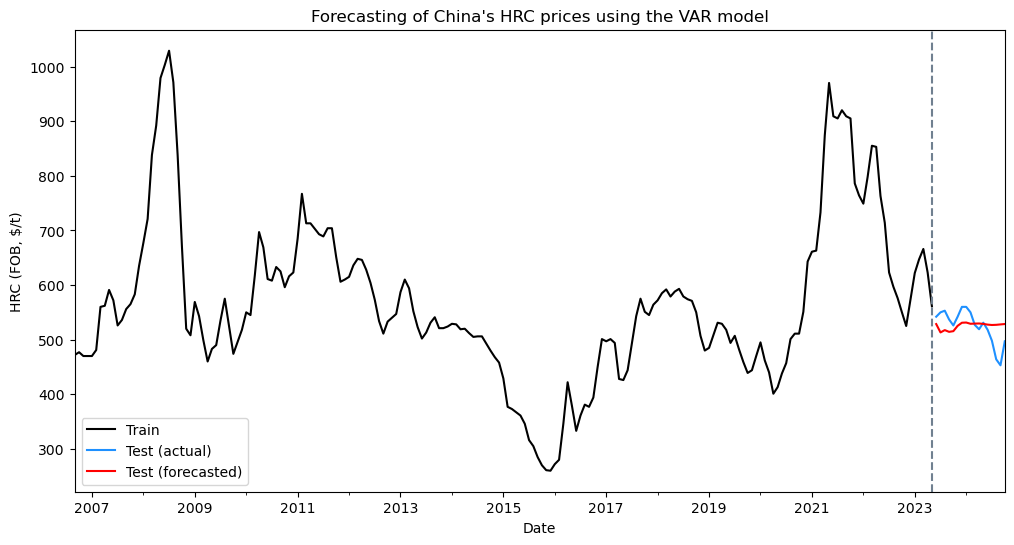

In [574]:
# TODO: smooth plot
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df_train['HRC (FOB, $/t)'].plot(color='k', label='Train')
final_df_test['HRC (FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_forecast_processed['HRC (FOB, $/t)_forecast'].plot(color='r', label='Test (forecasted)')

plt.title("Forecasting of China's HRC prices using the VAR model")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = final_df_train.index[-1], color = 'slategray', linestyle = 'dashed')
ax.legend()

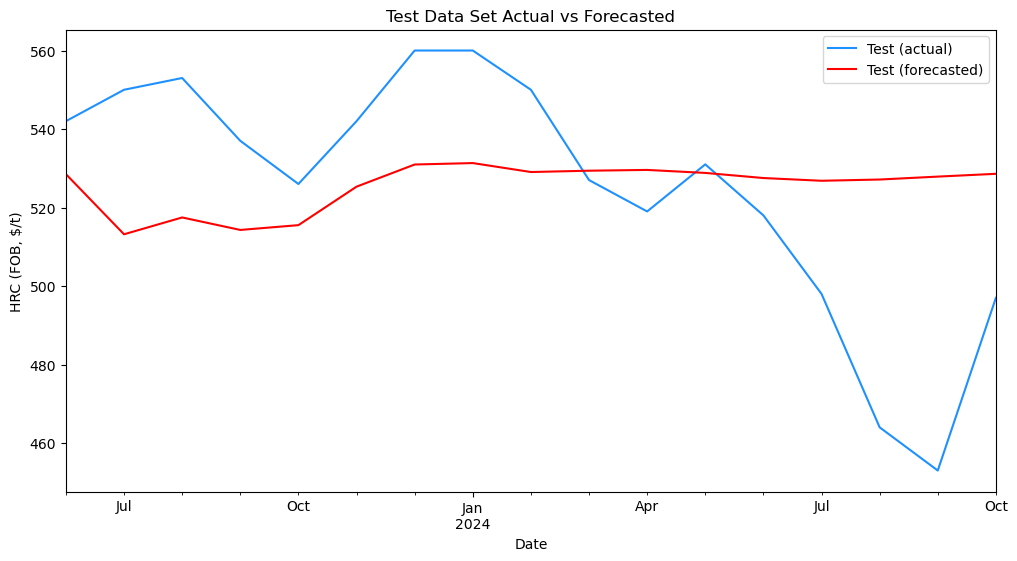

In [575]:
fig, ax = plt.subplots(figsize=(12, 6))

final_df_test['HRC (FOB, $/t)'].plot(color='dodgerblue', label='Test (actual)')
df_forecast_processed['HRC (FOB, $/t)_forecast'].plot(color='r', label='Test (forecasted)')

plt.title("Test Data Set Actual vs Forecasted")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
ax.legend()

In [576]:
# Error metrics for HRC
forecast = df_forecast_processed['HRC (FOB, $/t)_forecast'].values
actual = final_df_test['HRC (FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  25.733214114323506
Root Mean Squared Error:  32.031503358041704
Mean Absolute Percentage Error:  0.050612869320899534


In [577]:
# Error metrics for Iron Ore (CFR, $/t)
forecast = df_forecast_processed['Iron Ore (CFR, $/t)_forecast'].values
actual = final_df_test['Iron Ore (CFR, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  13.11250292063355
Root Mean Squared Error:  16.130380882423488
Mean Absolute Percentage Error:  0.10894713288760753


In [578]:
# Error metrics for HCC (Aus FOB, $/t)
forecast = df_forecast_processed['HCC (Aus FOB, $/t)_forecast'].values
actual = final_df_test['HCC (Aus FOB, $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  57.72629324326205
Root Mean Squared Error:  70.34604928682975
Mean Absolute Percentage Error:  0.19916837276376176


In [579]:
# Error metrics for Domestic Scrap (DDP Jiangsu incl. VAT $/t)
forecast = df_forecast_processed['Domestic Scrap (DDP Jiangsu incl. VAT $/t)_forecast'].values
actual = final_df_test['Domestic Scrap (DDP Jiangsu incl. VAT $/t)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  23.415297813908744
Root Mean Squared Error:  27.649576305733227
Mean Absolute Percentage Error:  0.06158878353322762


In [580]:
# Error metrics for Monthly Export of Semis & Finished Steel as % of Production
forecast = df_forecast_processed['Monthly Export of Semis & Finished Steel as % of Production_forecast'].values
actual = final_df_test['Monthly Export of Semis & Finished Steel as % of Production']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  3.593790237357622
Root Mean Squared Error:  4.670055730148026
Mean Absolute Percentage Error:  0.27596502273743156


In [581]:
# Error metrics for FAI in urban real estate development (y-o-y) Growth
forecast = df_forecast_processed['FAI in urban real estate development (y-o-y) Growth_forecast'].values
actual = final_df_test['FAI in urban real estate development (y-o-y) Growth']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  1.9017684438404263
Root Mean Squared Error:  2.0586481992312007
Mean Absolute Percentage Error:  0.20865174095836742


In [582]:
# Error metrics for Automobile Production (y-o-y)
forecast = df_forecast_processed['Automobile Production (y-o-y)_forecast'].values
actual = final_df_test['Automobile Production (y-o-y)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  6.461171409784161
Root Mean Squared Error:  12.590079476291859
Mean Absolute Percentage Error:  0.7228037591220082


In [583]:
# Error metrics for Civil Metal-Vessels/Steel Ships (y-o-y)
forecast = df_forecast_processed['Civil Metal-Vessels/Steel Ships (y-o-y)_forecast'].values
actual = final_df_test['Civil Metal-Vessels/Steel Ships (y-o-y)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  8.671308651065932
Root Mean Squared Error:  8.881187003567153
Mean Absolute Percentage Error:  5.03397820336007


In [584]:
# Error metrics for Household Fridges (y-o-y)
forecast = df_forecast_processed['Household Fridges (y-o-y)_forecast'].values
actual = final_df_test['Household Fridges (y-o-y)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  3.966839090329853
Root Mean Squared Error:  4.5619325753783775
Mean Absolute Percentage Error:  0.3068003984532929


In [585]:
# Error metrics for Air Conditioner (y-o-y)
forecast = df_forecast_processed['Air Conditioner (y-o-y)_forecast'].values
actual = final_df_test['Air Conditioner (y-o-y)']

mae = np.mean(np.abs(forecast - actual))
rmse = np.mean((forecast - actual)**2)**.5
mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)

Mean Absolute Error:  5.245453721853969
Root Mean Squared Error:  6.100617745342878
Mean Absolute Percentage Error:  0.33522597263907716


### Impulse Response Analysis

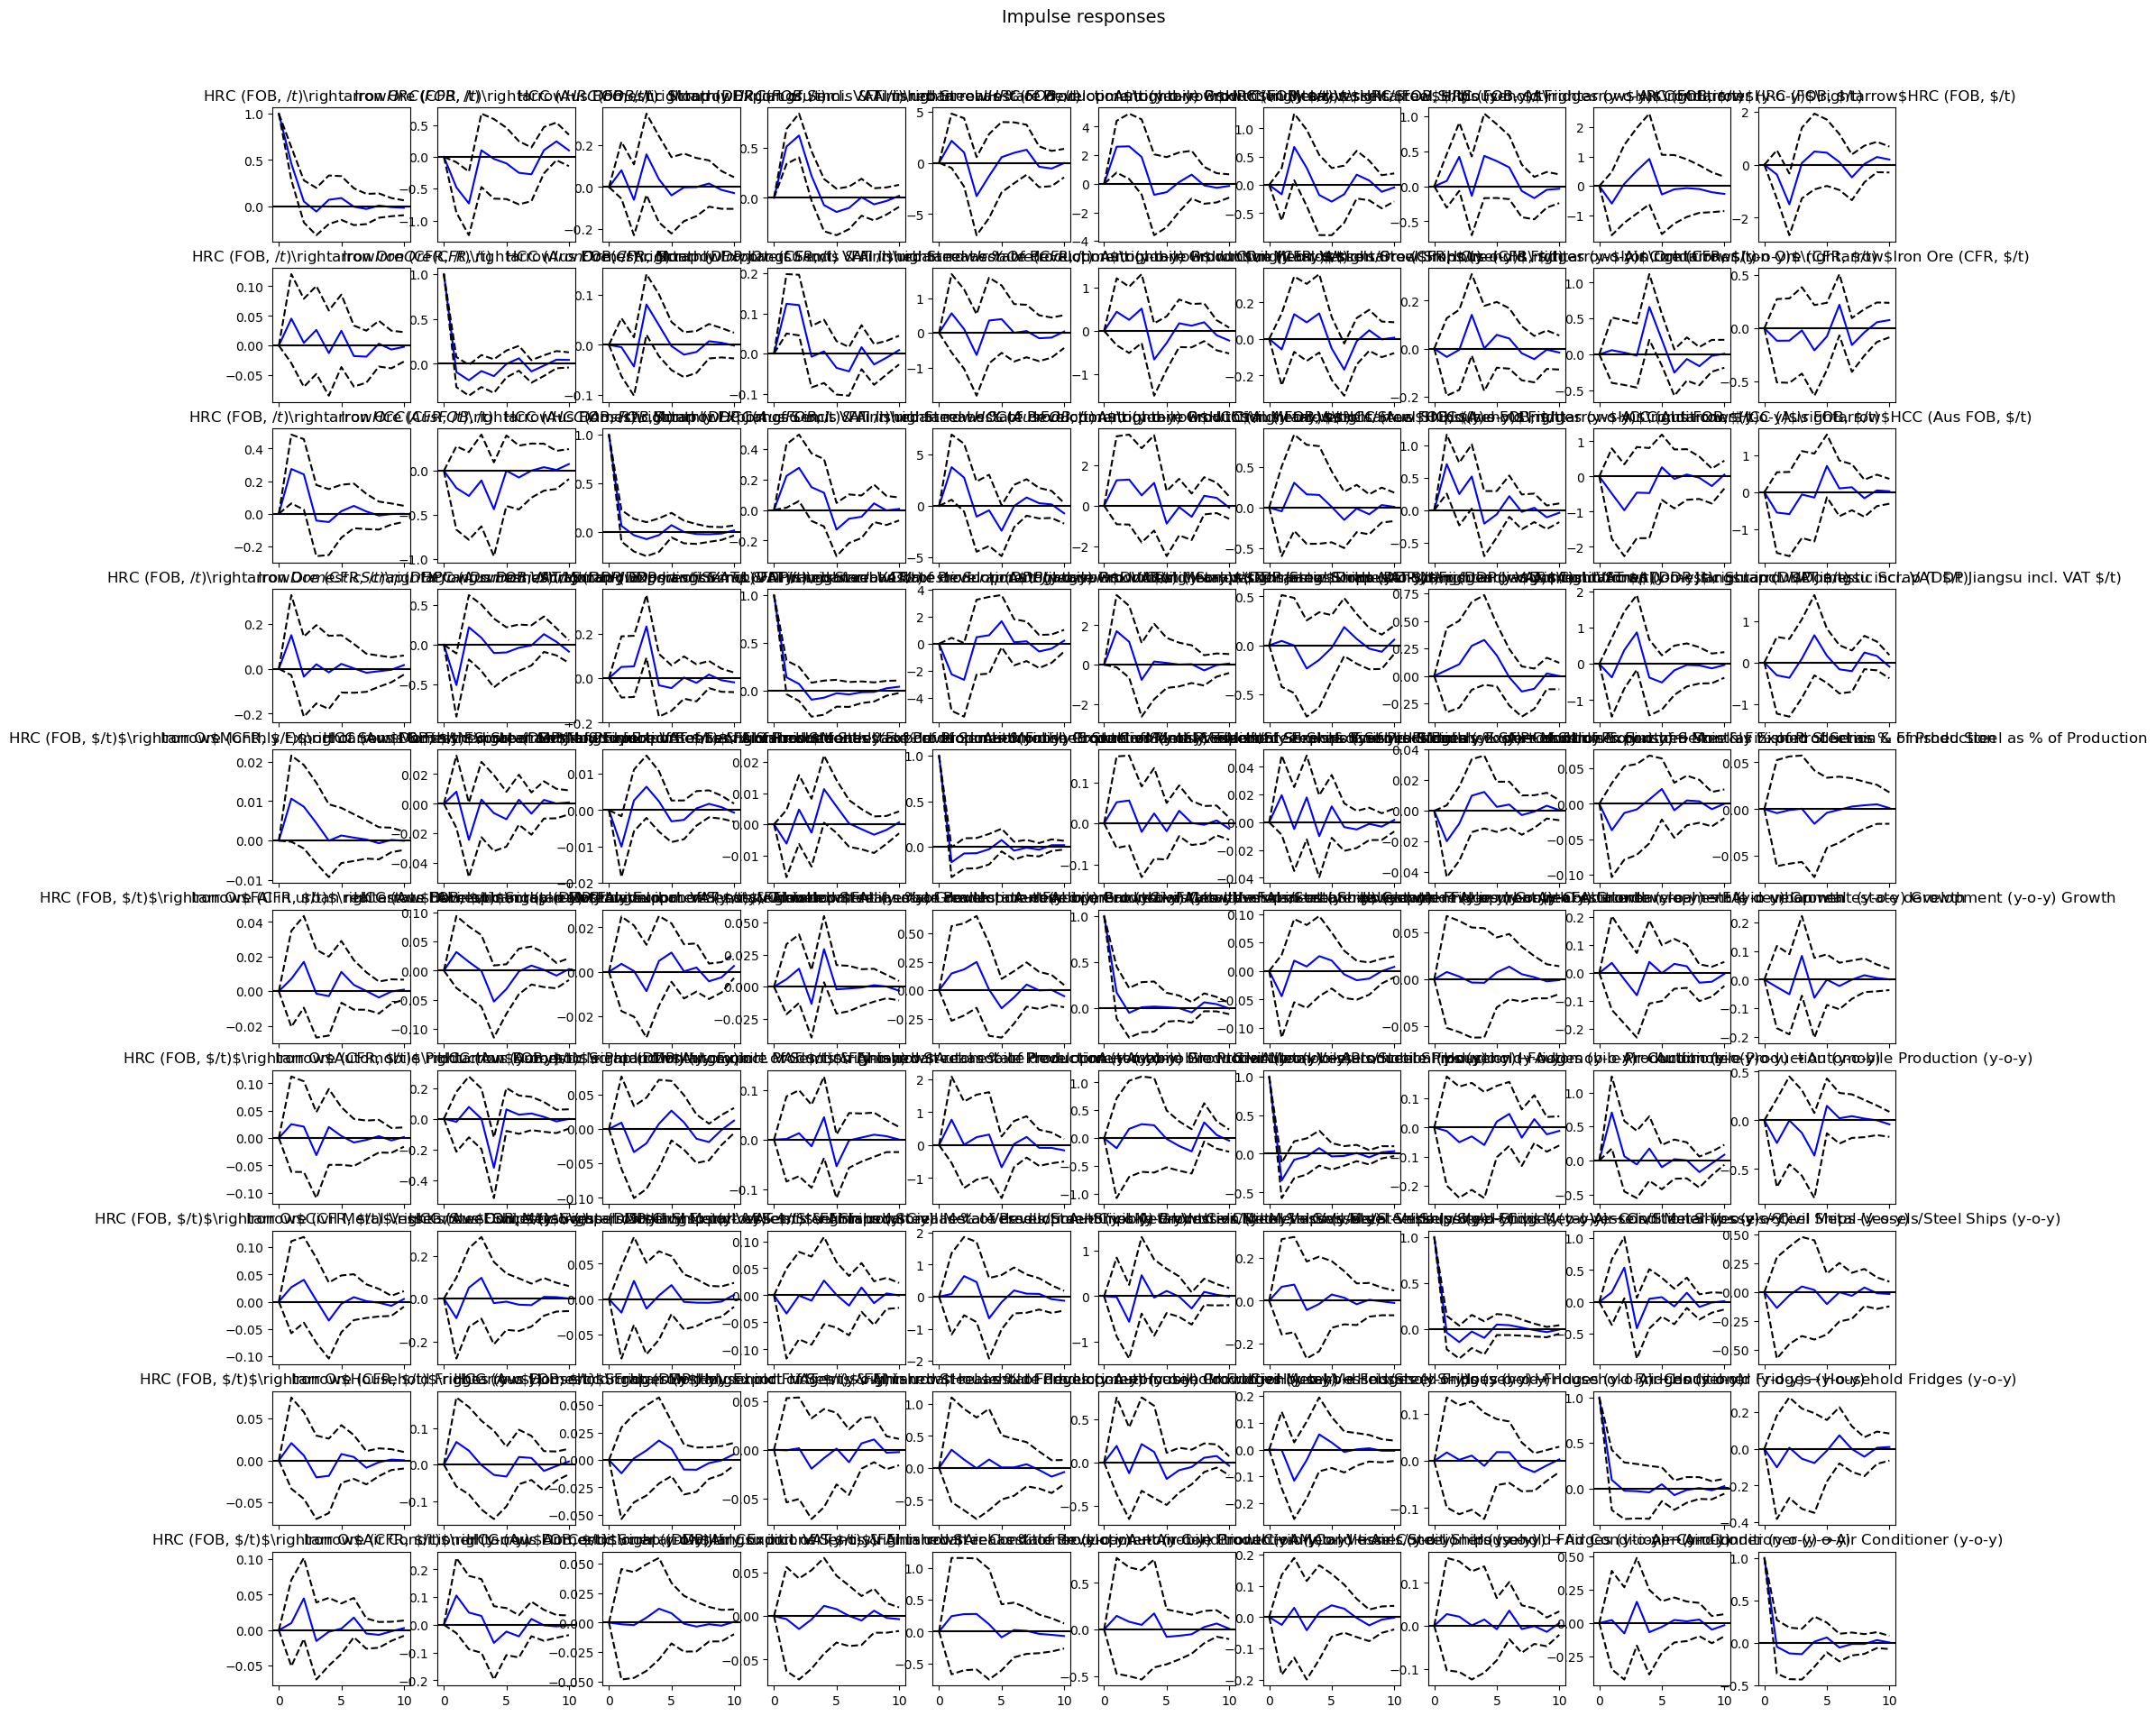

In [586]:
irf = model_fitted.irf(10)
#irf.plot(impulse='RM Cost \n($/t)', response='HRC \n(FOB, $/t)', figsize=(12,6))
irf.plot(figsize=(20,20))
plt.show()

## VAR model (for actual forecast)
The VAR model is trained on the full dataset.

In [587]:
# Read csv
file_path = '../data/final/wo_na.csv'
df2 = pd.read_csv(file_path)

df2.set_index('Date', inplace=True)
df2.index = pd.to_datetime(df2.index)

In [588]:
list_of_variables = ['Iron Ore (CFR, $/t)', 'HCC (Aus FOB, $/t)',
         'Domestic Scrap (DDP Jiangsu incl. VAT $/t)',
         'Monthly Export of Semis & Finished Steel as % of Production',
         'FAI in urban real estate development (y-o-y) Growth',
         'Automobile Production (y-o-y)', 'Civil Metal-Vessels/Steel Ships (y-o-y)',
         'Household Fridges (y-o-y)', 'Air Conditioner (y-o-y)']
hrc = ['HRC (FOB, $/t)']
final_cols = hrc + list_of_variables

final_df2 = df2.copy()
final_df2 = final_df2[final_cols]
final_df2.head()

HRC (FOB, $/t)  Iron Ore (CFR, $/t)  HCC (Aus FOB, $/t)  \
Date                                                                  
2006-09-01             472                   59                 116   
2006-10-01             477                   62                  85   
2006-11-01             470                   62                  84   
2006-12-01             470                   61                  90   
2007-01-01             470                   62                  98   

            Domestic Scrap (DDP Jiangsu incl. VAT $/t)  \
Date                                                     
2006-09-01                                         252   
2006-10-01                                         260   
2006-11-01                                         262   
2006-12-01                                         270   
2007-01-01                                         273   

            Monthly Export of Semis & Finished Steel as % of Production  \
Date                                                                      
2006-09-01                                          14.277778             
2006-10-01                                          13.657895             
2006-11-01                                          16.078947             
2006-12-01                                          15.512821             
2007-01-01                                          13.026316             

            FAI in urban real estate development (y-o-y) Growth  \
Date                                                              
2006-09-01                                               24.3     
2006-10-01                                               24.1     
2006-11-01                                               24.0     
2006-12-01                                               21.8     
2007-01-01                                               24.3     

            Automobile Production (y-o-y)  \
Date                                        
2006-09-01                           24.0   
2006-10-01                           25.1   
2006-11-01                           26.1   
2006-12-01                           27.0   
2007-01-01                           45.0   

            Civil Metal-Vessels/Steel Ships (y-o-y)  \
Date                                                  
2006-09-01                                      6.0   
2006-10-01                                     11.4   
2006-11-01                                      8.3   
2006-12-01                                     13.1   
2007-01-01                                      8.6   

            Household Fridges (y-o-y)  Air Conditioner (y-o-y)  
Date                                                            
2006-09-01                       34.2                      3.9  
2006-10-01                       31.8                      6.7  
2006-11-01                       28.9                      7.2  
2006-12-01                       15.8                     16.1  
2007-01-01                       15.8                     16.1

In [589]:
# Difference data to achieve stationarity
final_df2_differenced = final_df2.diff().dropna()

In [590]:
# Determine the best number of lags
model2 = VAR(final_df2_differenced)
x2 = model2.select_order(maxlags=12)
x2.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [591]:
# Use lag with the lowest AIC
model_fitted2 = model2.fit(4)
model_fitted2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Apr, 2025
Time:                     20:06:22
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    51.2743
Nobs:                     213.000    HQIC:                   47.4190
Log likelihood:          -7383.98    FPE:                3.01529e+19
AIC:                      44.8042    Det(Omega_mle):     5.18546e+18
--------------------------------------------------------------------
Results for equation HRC (FOB, $/t)
                                                                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------------------------------------
const                                                                  0.585135         1.847010            0.317  

In [592]:
# Employ the Durbin Watson's Statistic to check for serial correlation in the residuals.
# As values are close to 2, there is no significant serial correlation.

out2 = durbin_watson(model_fitted2.resid)

for col, val in zip(final_df2.columns, out2):
    print(col, ':', round(val, 2))

HRC (FOB, $/t) : 1.97
Iron Ore (CFR, $/t) : 2.02
HCC (Aus FOB, $/t) : 2.04
Domestic Scrap (DDP Jiangsu incl. VAT $/t) : 2.03
Monthly Export of Semis & Finished Steel as % of Production : 2.02
FAI in urban real estate development (y-o-y) Growth : 1.94
Automobile Production (y-o-y) : 1.95
Civil Metal-Vessels/Steel Ships (y-o-y) : 2.0
Household Fridges (y-o-y) : 1.99
Air Conditioner (y-o-y) : 1.98


In [593]:
# Using the last _ observations (since lag order is _) to forecast the following periods
lag_order2 = model_fitted2.k_ar
forecast_input2 = final_df2_differenced.values[-lag_order2:]
forecast_input2

array([[-20.        ,  -1.        , -12.        ,  -2.        ,
         -0.07713463,  -0.1       ,  -1.2       ,   0.1       ,
         -2.4       ,  -4.3       ],
       [-34.        ,  -7.        , -31.        , -30.        ,
          2.74575224,   0.        ,  -1.1       ,  -0.3       ,
          0.        ,  -1.7       ],
       [-11.        ,  -5.        , -19.        ,  -9.        ,
          1.002331  ,   0.1       ,  -0.7       ,   0.        ,
          0.2       ,   0.2       ],
       [ 44.        ,  10.        ,  17.        ,  17.        ,
          0.45232816,  -0.2       ,   0.3       ,   0.2       ,
          1.        ,   0.2       ]])

In [594]:
# Forecast the following _ periods
fc2 = model_fitted2.forecast(y=forecast_input2, steps=17)
fc_period2 = pd.date_range(start='11/1/2024', periods=17, freq='MS')
df_forecast2 = pd.DataFrame(fc2, index=fc_period2, columns=final_df2.columns + '_1d')
df_forecast2.index.name = 'Date'
df_forecast2

HRC (FOB, $/t)_1d  Iron Ore (CFR, $/t)_1d  HCC (Aus FOB, $/t)_1d  \
Date                                                                           
2024-11-01          19.405733                2.146433              28.112562   
2024-12-01           0.393028                0.441906              16.970414   
2025-01-01           5.100750                1.941511              -5.196327   
2025-02-01          10.632432                2.049517              -8.549116   
2025-03-01           6.852293                3.026626               0.196417   
2025-04-01          -2.246912               -0.442230               2.933537   
2025-05-01          -4.174677               -2.045662               1.972330   
2025-06-01          -0.795270               -1.488854              -0.494445   
2025-07-01           0.310747                0.053009              -1.673525   
2025-08-01          -0.381540                0.679732               0.457513   
2025-09-01          -0.443803                0.264135               1.241164   
2025-10-01           0.344261                0.211272               1.631055   
2025-11-01           1.237219                0.169833               1.227967   
2025-12-01           1.247853                0.472737               0.282941   
2026-01-01           0.590417                0.716860               0.477057   
2026-02-01          -0.087495                0.350493               0.424126   
2026-03-01          -0.259621                0.040252               0.555621   

            Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d  \
Date                                                        
2024-11-01                                      -3.217672   
2024-12-01                                       1.988942   
2025-01-01                                       9.813901   
2025-02-01                                       2.248489   
2025-03-01                                       2.328163   
2025-04-01                                      -2.730486   
2025-05-01                                      -3.576975   
2025-06-01                                       0.136381   
2025-07-01                                       0.924078   
2025-08-01                                       0.932438   
2025-09-01                                       0.692195   
2025-10-01                                       0.273845   
2025-11-01                                       0.764061   
2025-12-01                                       0.726186   
2026-01-01                                       0.243035   
2026-02-01                                       0.142252   
2026-03-01                                       0.204974   

            Monthly Export of Semis & Finished Steel as % of Production_1d  \
Date                                                                         
2024-11-01                                          -0.228613                
2024-12-01                                          -0.320143                
2025-01-01                                           0.267119                
2025-02-01                                           0.336962                
2025-03-01                                           0.174999                
2025-04-01                                          -0.006803                
2025-05-01                                          -0.185422                
2025-06-01                                          -0.074824                
2025-07-01                                           0.049814                
2025-08-01                                           0.053237                
2025-09-01                                          -0.022724                
2025-10-01                                          -0.065854                
2025-11-01                                          -0.009183                
2025-12-01                                           0.022336                
2026-01-01                                           0.035786                
2026-

In [595]:
# De-difference forecasted results
df_forecast2_processed = invert_transformation(final_df2, df_forecast2)

df_forecast2_processed.to_csv('../data/final/var_forecast_actual.csv', index=True)

In [596]:
df_forecast2_processed

HRC (FOB, $/t)_1d  Iron Ore (CFR, $/t)_1d  HCC (Aus FOB, $/t)_1d  \
Date                                                                           
2024-11-01          19.405733                2.146433              28.112562   
2024-12-01           0.393028                0.441906              16.970414   
2025-01-01           5.100750                1.941511              -5.196327   
2025-02-01          10.632432                2.049517              -8.549116   
2025-03-01           6.852293                3.026626               0.196417   
2025-04-01          -2.246912               -0.442230               2.933537   
2025-05-01          -4.174677               -2.045662               1.972330   
2025-06-01          -0.795270               -1.488854              -0.494445   
2025-07-01           0.310747                0.053009              -1.673525   
2025-08-01          -0.381540                0.679732               0.457513   
2025-09-01          -0.443803                0.264135               1.241164   
2025-10-01           0.344261                0.211272               1.631055   
2025-11-01           1.237219                0.169833               1.227967   
2025-12-01           1.247853                0.472737               0.282941   
2026-01-01           0.590417                0.716860               0.477057   
2026-02-01          -0.087495                0.350493               0.424126   
2026-03-01          -0.259621                0.040252               0.555621   

            Domestic Scrap (DDP Jiangsu incl. VAT $/t)_1d  \
Date                                                        
2024-11-01                                      -3.217672   
2024-12-01                                       1.988942   
2025-01-01                                       9.813901   
2025-02-01                                       2.248489   
2025-03-01                                       2.328163   
2025-04-01                                      -2.730486   
2025-05-01                                      -3.576975   
2025-06-01                                       0.136381   
2025-07-01                                       0.924078   
2025-08-01                                       0.932438   
2025-09-01                                       0.692195   
2025-10-01                                       0.273845   
2025-11-01                                       0.764061   
2025-12-01                                       0.726186   
2026-01-01                                       0.243035   
2026-02-01                                       0.142252   
2026-03-01                                       0.204974   

            Monthly Export of Semis & Finished Steel as % of Production_1d  \
Date                                                                         
2024-11-01                                          -0.228613                
2024-12-01                                          -0.320143                
2025-01-01                                           0.267119                
2025-02-01                                           0.336962                
2025-03-01                                           0.174999                
2025-04-01                                          -0.006803                
2025-05-01                                          -0.185422                
2025-06-01                                          -0.074824                
2025-07-01                                           0.049814                
2025-08-01                                           0.053237                
2025-09-01                                          -0.022724                
2025-10-01                                          -0.065854                
2025-11-01                                          -0.009183                
2025-12-01                                           0.022336                
2026-01-01                                           0.035786                
2026-

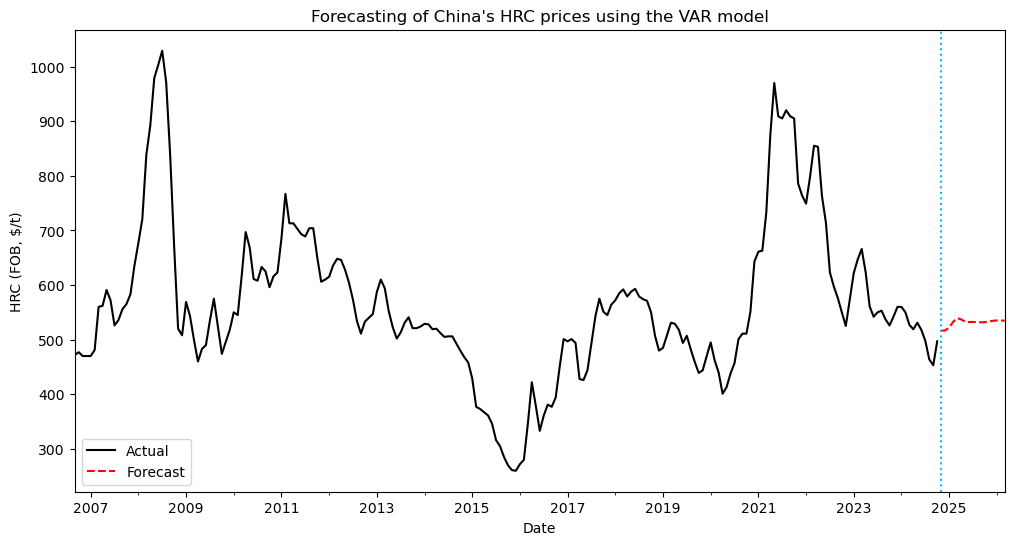

In [597]:
# TODO: smooth plot
# Compare forecasted with actual results
fig, ax = plt.subplots(figsize=(12, 6))

final_df2['HRC (FOB, $/t)'].plot(color='k', label='Actual')
df_forecast2_processed['HRC (FOB, $/t)_forecast'].plot(color='r', linestyle ='dashed', label='Forecast')

plt.title("Forecasting of China's HRC prices using the VAR model")
plt.ylabel("HRC (FOB, $/t)")
plt.xlabel("Date")
plt.axvline(x = '2024-11-01', color = 'deepskyblue', linestyle = 'dotted')
ax.legend()